<a href="https://colab.research.google.com/github/leroyokosi/deep_learning_diabetic_retinopathy/blob/main/new_diabetic_retinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO LIST FOR THIS PROJECT

1. Pick a dataset
2. Download the dataset
3. Import the dataset using PyTorch
4. Explore the dataset
5. Prepare the dataset for training


# Dowload the dataset

using the opendatasets and download the dataset from https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

In [54]:
!pip install opendatasets --upgrade --quiet

In [55]:
import opendatasets as od

In [56]:
dataset_url = 'https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered'

In [57]:
od.download(dataset_url)

Skipping, found downloaded files in "./diabetic-retinopathy-224x224-gaussian-filtered" (use force=True to force download)


In [58]:
data_dir = './diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'

In [59]:
import os

In [60]:
os.listdir(data_dir)

['Moderate', 'Proliferate_DR', 'Mild', 'Severe', 'No_DR']

In [61]:
# We need to delete the .ipynb_checkpoints from the lists because it will break the code

# import shutil

# shutil.rmtree(data_dir + '/.ipynb_checkpoints')

In [62]:
os.listdir(data_dir)

['Moderate', 'Proliferate_DR', 'Mild', 'Severe', 'No_DR']

In [63]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

Moderate : 999
Proliferate_DR : 295
Mild : 370
Severe : 193
No_DR : 1805


In the above we observe that the distribution is quite uneven, we can make this balance by using different techniques such as oversampling, undersampling.  

# Import the dataset into Pytorch

Use the `ImageFolder` class from `torchvision`

In [64]:
from torchvision.datasets import ImageFolder

In [65]:
dataset = ImageFolder(data_dir)

In [66]:
len(dataset)

3662

In [67]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=224x224 at 0x7F162A8F6A40>, 0)

In [68]:
dataset.classes

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

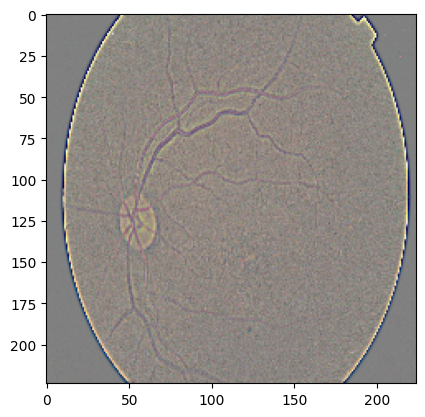

In [70]:
img, label = dataset[9]

plt.imshow(img)

In [71]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

# import torchvision.transforms as tt

# dataset = ImageFolder(data_dir, tt.Compose([tt.ToTensor()]))

# we use the above code if we don't need to resize - we resize to save the memory in gpu

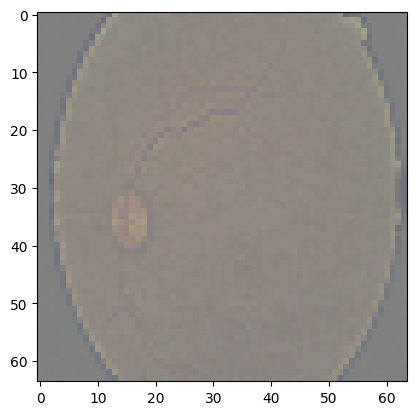

In [72]:
img, label = dataset[9]
plt.imshow(img.permute((1, 2, 0)))

In [73]:
# sharing our data into training data and validation data

val_pct = 0.1 #this is the validation percentage
val_size = int(val_pct * len(dataset))  #converted to interger for easy calculation
train_size = len(dataset) - val_size

train_size, val_size

(3296, 366)

In [74]:
# we use the random_split to split a dataset into non-overlapping new dataset
# this can be found on the pytorch library

from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])

len(train_ds), len(valid_ds)

(3296, 366)

Now that we have a training set and validation set, next thing would be to create data loader to work with data in batches. 

In [149]:
from torch.utils.data import DataLoader


batch_size = 128

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=2, 
                      pin_memory=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=2, 
                    pin_memory=True)

In [76]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

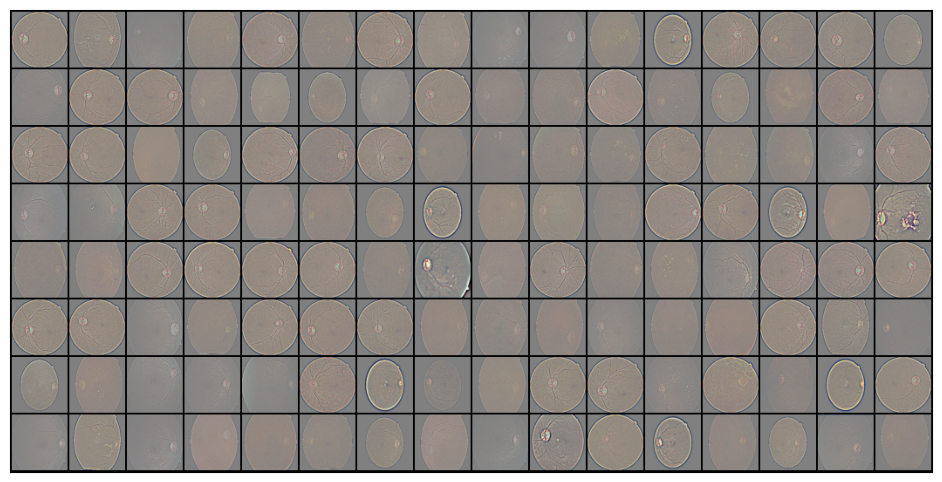

In [77]:
show_batch(train_dl)

# GPU Utilities and classes

In [78]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [79]:
torch.cuda.is_available()

True

In [80]:
# this is going to find the gpu available, if there is not gpu it will detect a cpu

device = get_default_device()

device

device(type='cuda')

In [81]:
#to move an image tensor to the device

img, label = dataset[0]

In [82]:
img

tensor([[[0.5020, 0.4980, 0.5020,  ..., 0.5020, 0.5020, 0.5059],
         [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
         [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
         ...,
         [0.5059, 0.5059, 0.5020,  ..., 0.5059, 0.5020, 0.5020],
         [0.5020, 0.4980, 0.4980,  ..., 0.5020, 0.5020, 0.5020],
         [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020]],

        [[0.5020, 0.5059, 0.5098,  ..., 0.5020, 0.5020, 0.5059],
         [0.5059, 0.5020, 0.5098,  ..., 0.5059, 0.5020, 0.5020],
         [0.5020, 0.5020, 0.5059,  ..., 0.5020, 0.5059, 0.5059],
         ...,
         [0.5059, 0.5059, 0.5020,  ..., 0.5020, 0.5059, 0.5059],
         [0.5020, 0.5059, 0.5059,  ..., 0.5020, 0.5020, 0.5059],
         [0.4980, 0.5059, 0.5059,  ..., 0.4980, 0.5020, 0.5020]],

        [[0.5020, 0.5020, 0.5059,  ..., 0.5020, 0.5020, 0.5020],
         [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
         [0.4980, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.

In [83]:
img.shape

torch.Size([3, 64, 64])

In [84]:
img.device

device(type='cpu')

In [85]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [86]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

#Model and training utilities

Note: this is a single image classification problem so we can use the image classification base class set up earlier (copied from joivan notebook)

In [87]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [88]:
@torch.no_grad()
def evaluate(model, val_loader):
    "Evaluates the model's performance on the validation set"
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

#model

In [89]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 256 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 2 x 2 
                                        nn.Flatten(), # 128 x 2048
                                        nn.Dropout(0.2), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

The above code whic is copied from jovian notebook,we notie that the res9 architecture is desgined for an image size of 64 x 64 pixels

In [90]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [91]:
model.conv1[0].weight.device

device(type='cuda', index=0)

In [92]:
for batch in train_dl:
  images, labels = batch
  print('images.shape', images.shape)
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape', preds.shape)
  # print(preds)
  break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


# Training

In [93]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.603484869003296, 'val_acc': 0.48480114340782166}]

In [94]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.6197, val_loss: 2.6560, val_acc: 0.0785
Epoch [1], train_loss: 0.9435, val_loss: 1.5707, val_acc: 0.3573
Epoch [2], train_loss: 0.8648, val_loss: 1.3706, val_acc: 0.6149
Epoch [3], train_loss: 0.8415, val_loss: 0.7938, val_acc: 0.6947
Epoch [4], train_loss: 0.8139, val_loss: 0.8556, val_acc: 0.6804


In [95]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.0361, val_loss: 1.1519, val_acc: 0.6587
Epoch [1], train_loss: 0.8587, val_loss: 0.9109, val_acc: 0.7111
Epoch [2], train_loss: 0.8339, val_loss: 0.9351, val_acc: 0.7229
Epoch [3], train_loss: 0.8072, val_loss: 0.9117, val_acc: 0.6774
Epoch [4], train_loss: 0.7789, val_loss: 0.8092, val_acc: 0.7016


In [100]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.7571, val_loss: 0.7935, val_acc: 0.7190
Epoch [1], train_loss: 0.7470, val_loss: 0.7466, val_acc: 0.7164
Epoch [2], train_loss: 0.7347, val_loss: 0.7426, val_acc: 0.7333
Epoch [3], train_loss: 0.7315, val_loss: 0.7722, val_acc: 0.7220
Epoch [4], train_loss: 0.7308, val_loss: 0.7464, val_acc: 0.7458


In [105]:
history += fit(5, 0.0001, model, train_dl, valid_dl)

Epoch [0], train_loss: 0.7370, val_loss: 0.7465, val_acc: 0.7380
Epoch [1], train_loss: 0.7289, val_loss: 0.7457, val_acc: 0.7437
Epoch [2], train_loss: 0.7241, val_loss: 0.7381, val_acc: 0.7380
Epoch [3], train_loss: 0.7228, val_loss: 0.7392, val_acc: 0.7380
Epoch [4], train_loss: 0.7172, val_loss: 0.7398, val_acc: 0.7380


In [106]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

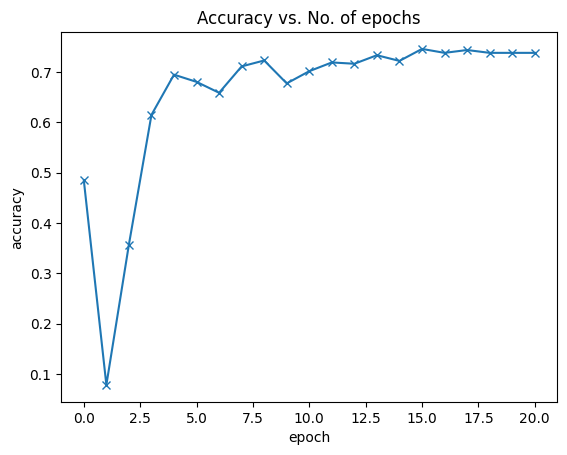

In [107]:
plot_accuracies(history)

In [108]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

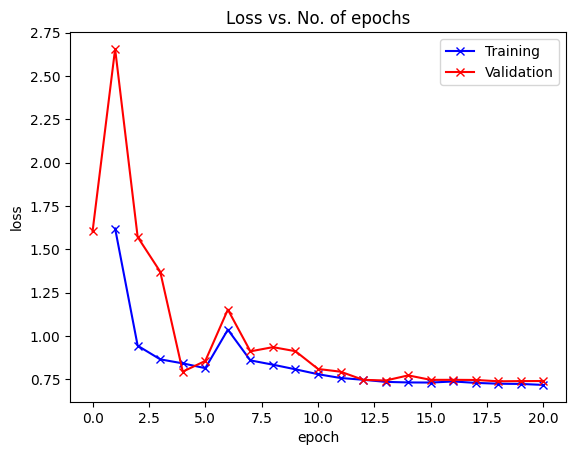

In [109]:
plot_losses(history)

# record the results

In [ ]:
# use code from jovian

In [111]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [122]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

# img, label = valid_ds[9]
# #display the image of the above 




Target: No_DR
Prediction: No_DR


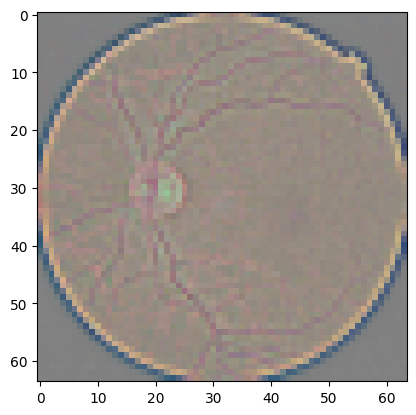

In [127]:
show_image_prediction(*valid_ds[300])

Target: No_DR
Prediction: No_DR


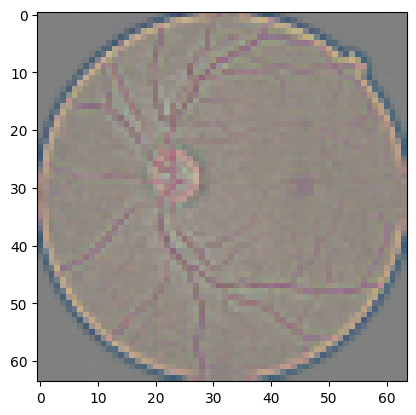

In [128]:
show_image_prediction(*valid_ds[234])

Target: Moderate
Prediction: Moderate


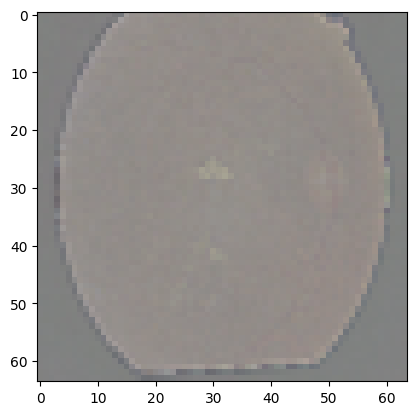

In [130]:
show_image_prediction(*valid_ds[295])

Target: Moderate
Prediction: Moderate


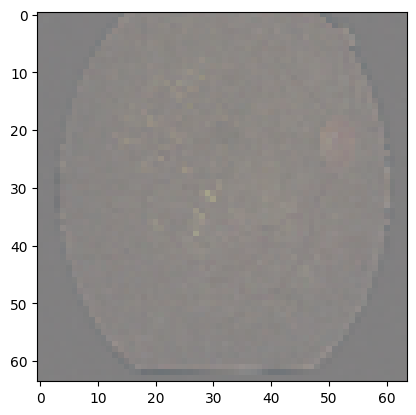

In [131]:
show_image_prediction(*valid_ds[34])

Target: Moderate
Prediction: Moderate


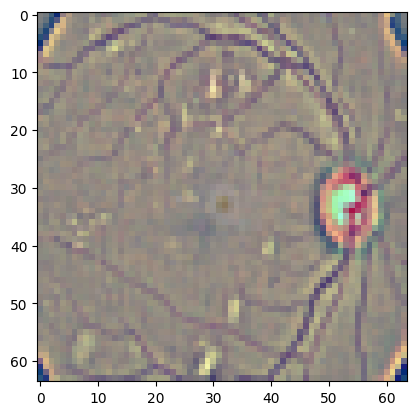

In [132]:
show_image_prediction(*valid_ds[45])

Target: No_DR
Prediction: No_DR


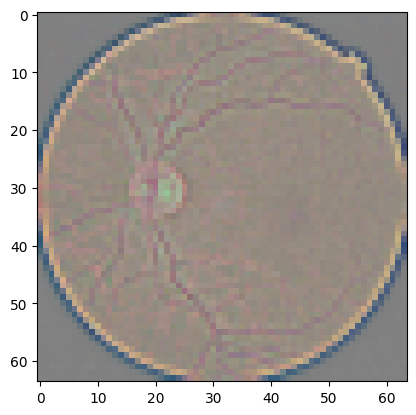

In [137]:
show_image_prediction(*valid_ds[300])

Target: No_DR
Prediction: No_DR


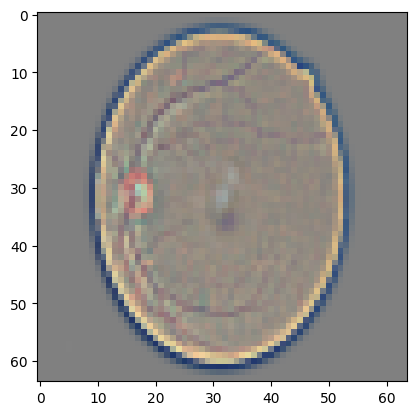

In [138]:
show_image_prediction(*valid_ds[270])

Target: No_DR
Prediction: No_DR


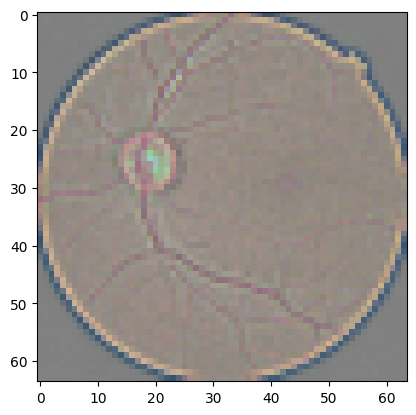

In [139]:
show_image_prediction(*valid_ds[222])

Target: Proliferate_DR
Prediction: Mild


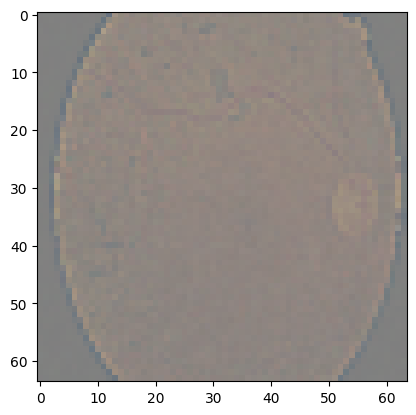

In [140]:
show_image_prediction(*valid_ds[111])

Target: Proliferate_DR
Prediction: Moderate


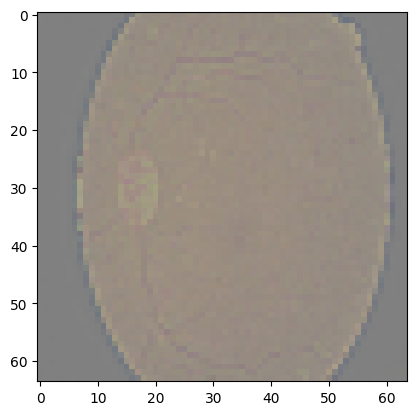

In [141]:
show_image_prediction(*valid_ds[97])

Target: Proliferate_DR
Prediction: Moderate


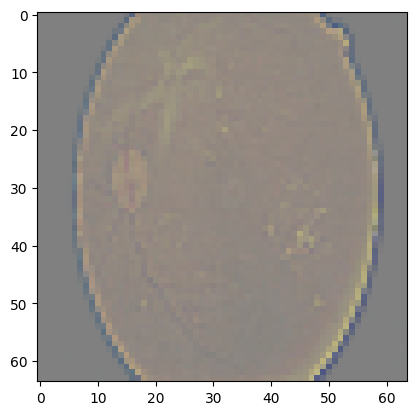

In [142]:
show_image_prediction(*valid_ds[60])

#Transfer Learning

In [143]:
from torchvision import models

class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [156]:
model = to_device(ResNet34(len(dataset.classes), pretrained=True), device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [157]:
model

ResNet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [148]:
import torchvision.transforms as tt

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(img_size),
                                            tt.RandomCrop(img_size),
                                            tt.ToTensor(), 
                                            tt.Normalize(*imagenet_stats)]))

In [150]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

batch_size = 64

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=2, 
                      pin_memory=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=2, 
                    pin_memory=True)

In [151]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [153]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [163]:
model = to_device(ResNet34(len(dataset.classes), pretrained=True), device)

In [164]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.7387771606445312, 'val_acc': 0.14311593770980835}]

In [165]:
history += fit_one_cycle(8, 0.001, model, train_dl, 
              valid_dl, weight_decay=0.1, 
              grad_clip=0.1, opt_func=torch.optim.Adam)

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.8641, val_loss: 0.7680, val_acc: 0.7263


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.7055, val_loss: 1.1582, val_acc: 0.5958


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.7521, val_loss: 1.1942, val_acc: 0.5671


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.7429, val_loss: 127.7959, val_acc: 0.1493


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.7209, val_loss: 1.4063, val_acc: 0.5026


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6854, val_loss: 1.0143, val_acc: 0.5682


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.6105, val_loss: 0.7717, val_acc: 0.7320


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.5397, val_loss: 0.6410, val_acc: 0.7512


In [166]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

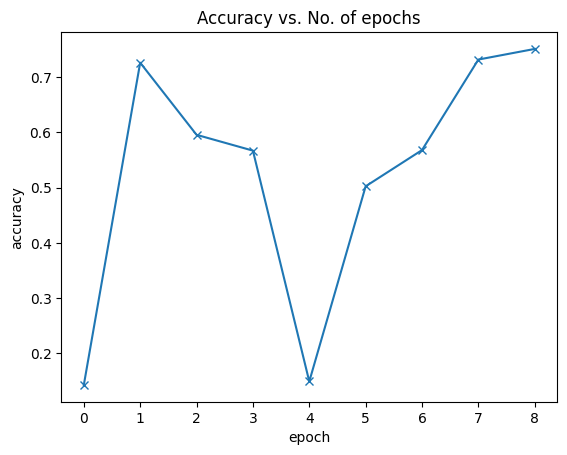

In [168]:
plot_accuracies(history)

In [167]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

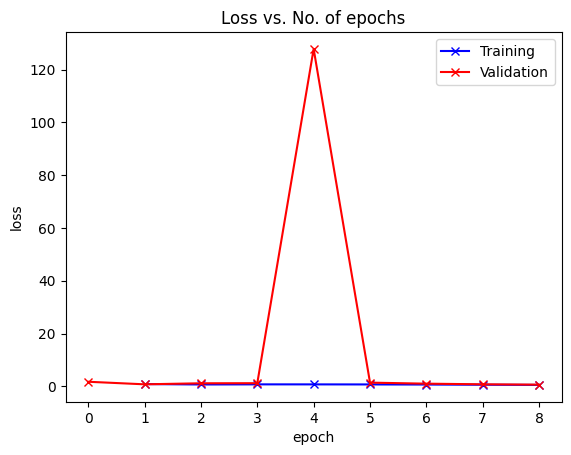

In [169]:
plot_losses(history)

In [170]:
import numpy as np

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

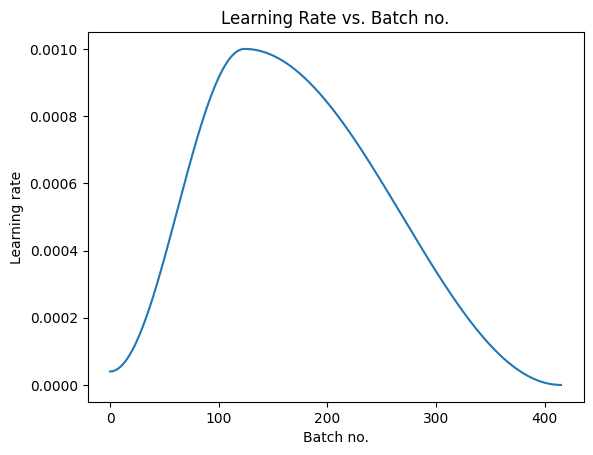

In [171]:
plot_lrs(history)

In [172]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label: Moderate (1)
predicted: Moderate


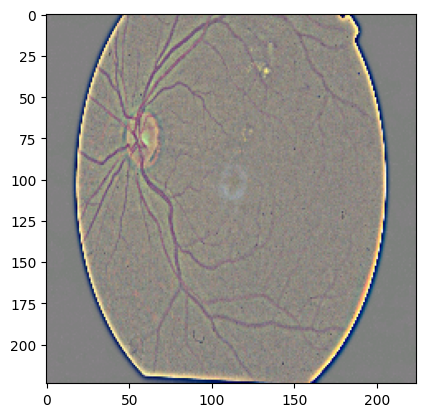

In [174]:
img, label = valid_ds[23]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('predicted:', pred)